단기 전력 부하 예측 (다음시점)
AMI + 날씨 -> EMS 의 필요성 

In [48]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data_csv/amiwea.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp")          # 데이터로드

In [49]:
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek        # 시간파생

In [50]:
df["lag_1"] = df["consumption"].shift(1)
df["lag_24"] = df["consumption"].shift(24)      #lag 설정

In [51]:
df_ml = df.dropna()         #결측치 제거

In [52]:
features = [
    "temperature",
    "humidity",
    "windSpeed",
    "hour",
    "dayofweek",
    "lag_1",
    "lag_24"
]

X = df_ml[features]
y = df_ml["consumption"]            #입력/타깃 정의

In [53]:
split_idx = int(len(df_ml) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]            #train/test 분할

RandomForest (설명이 쉬움)

In [54]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
y_pred = model.predict(X_test)# 예측 먼저

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))# 평가

mae, rmse

(3.3434343760732683, np.float64(4.160206819426645))

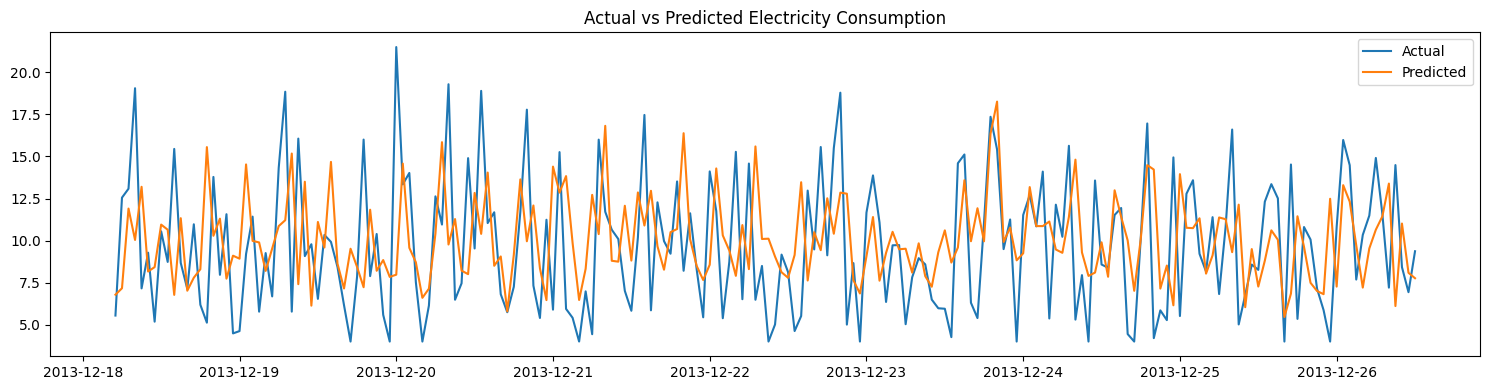

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(y_test.index[:200], y_test.values[:200], label="Actual")
plt.plot(y_test.index[:200], y_pred[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Electricity Consumption")
plt.tight_layout()
plt.show()          # 예측 및 실제 시각화 

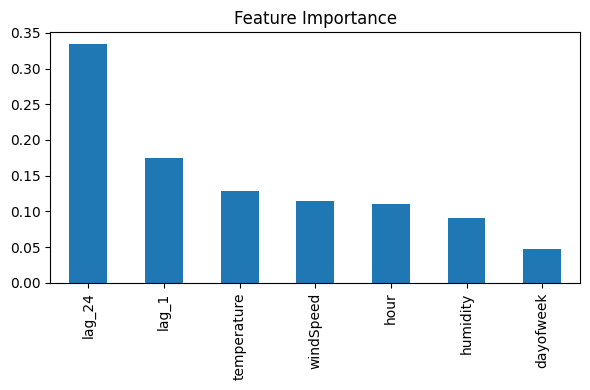

In [57]:
importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.plot(kind="bar", figsize=(6, 4))
plt.title("Feature Importance")
plt.tight_layout()
plt.show()          #Feature Importance

In [58]:
# RandomForest 예측
y_pred_rf = model.predict(X_test)  # RF 모델일 때

pred_rf = pd.DataFrame({
    "timestamp": y_test.index,
    "actual": y_test.values,
    "pred_rf": y_pred_rf
})

pred_rf.to_csv("../data_csv/pred_rf_test.csv", index=False)

“AMI 기반 전력 소비 데이터에 기온·습도 등 외생 변수와
시간·지연(lag) 특성을 결합한 결과,
단기 전력 부하를 합리적인 오차 범위 내에서 예측할 수 있음을 확인하였다.
이는 예측 기반 에너지 관리 시스템(EMS)의 적용 가능성을 시사한다.”

XGBoost

In [59]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [60]:
y_pred_xgb = model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

mae_xgb, rmse_xgb       #예측 및 평기 

(3.221692540007724, np.float64(4.01701000002476))

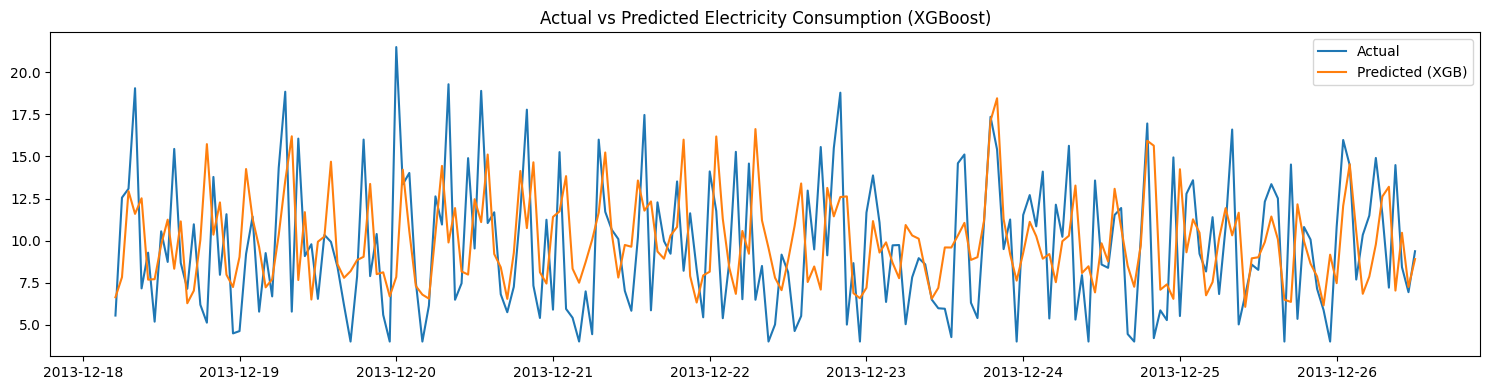

In [61]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.index[:200], y_test.values[:200], label="Actual")
plt.plot(y_test.index[:200], y_pred_xgb[:200], label="Predicted (XGB)")
plt.legend()
plt.title("Actual vs Predicted Electricity Consumption (XGBoost)")
plt.tight_layout()
plt.show()              #실제랑 예측 

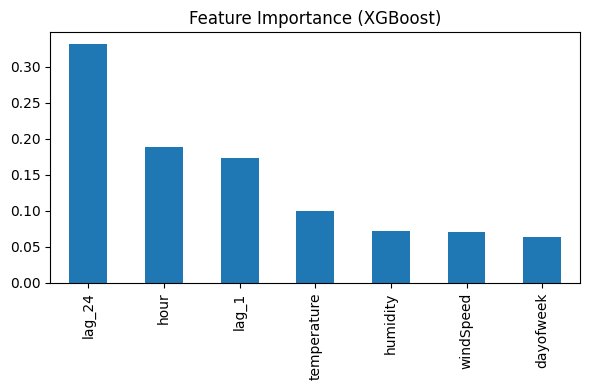

In [62]:
importances_xgb = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances_xgb.plot(kind="bar", figsize=(6, 4))
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()          #feature importance

In [63]:
# XGBoost 예측
y_pred_xgb = model.predict(X_test)  # XGB 모델일 때

pred_xgb = pd.DataFrame({
    "timestamp": y_test.index,
    "actual": y_test.values,
    "pred_xgb": y_pred_xgb
})

pred_xgb.to_csv("../data_csv/pred_xgb_test.csv", index=False)